In [4]:
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torch
import torchaudio as T
import IPython.display as ipd
from IPython.core.display import display
from model import UNet
import imageio

from inference import SDESampling, SDESampling2, SDESampling3, ODESampling, ScipySolver, ForwardScipySolver, \
        DDIMSampling, ForwardODESampling, ForwardDDIMSampling, SDEInpainting, SDEInpainting2, RegenerateSDESampling,\
    RandomDDIMSampling, ClassMixingSDE, ClassMixingSDE2, ClassMixingODE, ClassMixingDDIM, RandomClassMixingDDIM

from inference import compute_interpolation_in_latent

from sde import SDE, VpSdeSigmoid, VpSdeCos, SubVpSdeCos, GeneralizedSubVpSdeCos

T.set_audio_backend('sox')
device=torch.device('cuda:0')

#model_dir = os.getcwd() + '/saved_weights/weights_vp_sigmoid.pt'
model_dir = os.getcwd() + '/saved_weights/weights_vp.pt'
#model_dir = os.getcwd() + '/saved_weights/weights_subvp.pt'

checkpoint = torch.load(model_dir)
model = UNet().to(device)
#model.load_state_dict(checkpoint['model'])

def load_to_device(path, size):
    """
    load an audio to the device
    """
    audio, sr = T.load(path)
    audio = audio[:, :size]
    audio = audio.to(device)
    return audio

def plot_and_hear(audio):
    """
    plot and hear a cuda tensor of sound
    """
    display(ipd.Audio(audio.cpu(), rate=44100))
    plt.plot(audio.cpu().t().numpy())
    
def load_ema_weights(model, model_dir):
    checkpoint = torch.load(model_dir)
    dic_ema = {}
    for (key, tensor) in zip(checkpoint['model'].keys(), checkpoint['ema_weights']):
        dic_ema[key] = tensor
    model.load_state_dict(dic_ema)
    return model

model = load_ema_weights(model, model_dir)


sns.set()


/home/simon/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/torchaudio/backend/utils.py:59: UserWarning: "sox" backend is deprecated and will be removed in 0.9.0. Please use "sox_io" backend.
  warnings.warn(


# Unconditional Sampling of drums

1st Step : choose the SDE, make sure that you loaded the corresponding weights in the first box

In [6]:
sde = VpSdeCos()

2nd Step : Choose the sampler (python Classes). You have the choice between 7 samplers.
3 SDE samplers:
- SDESampling: args of the predict function = (noise, nb_steps). Euler-Maruyama discretization of the SDE as in https://arxiv.org/abs/2011.13456. 
This is the less precise SDE discretization
- SDESampling2: args of the predict function = (noise, nb_steps). DDPM-like discretization of the SDE as in https://arxiv.org/abs/2107.00630.
This is the most precise SDE discretization
- SDE Sampling3: args of the predict function = (noise, nb_steps). DDIM-like discretization of the SDE as in CRASH (https://arxiv.org/abs/2106.07431) Alg. 6. 
This is an intermediate SDE discretization in terms of precision

3 Deterministic Samplers:
- ODESampling: args of the predict function = (noise, nb_steps). Euler discretization of the ODE as in CRASH Alg. 3. It is the less precise deterministic method. (it needs min 200 steps)
- DDIMSampling: args of the predict function = (noise, nb_steps). Deterministic DDIM discretization. It corresponds to the reparameterization of the ODE. It is the Alg. 5 in CRASH. It is a great method. You can obtain nice drums with only 30 or 50 steps (even less sometimes !). 
- ScipySolver: args of the predict function = (noise). RK45 discretization of the ODE with atol=rtol=1e-5. Gives similar results than DDIMSampling.

1 intermediate sampler for which you choose the stochasticity of the model:
- RandomDDIMSampling: args of the predict function = (noise, eta, nb_steps). Intermediate DDIM. eta (float between 0 and 1) is the stochasticity level. For eta = 0.0 it corresponds to DDIMSampling and for eta = 1.0 it corresponds to SDESampling2. 

In [200]:
#sampler = SDESampling(model, sde)
sampler = SDESampling2(model, sde)
#sampler = SDESampling3(model, sde)

#sampler = ODESampling(model, sde)
#sampler = DDIMSampling(model, sde)
#sampler = ScipySolver(model, sde)

#sampler = RandomDDIMSampling(model, sde)

Then, you need to create a GPU tensor of size (batch_size, 21000) with isotropic Gaussians

In [218]:
noise = torch.randn(10, 21000, device=device)

And apply the .predict function of the class to generate in parallel n=batch_size drums

In [217]:
drums = sampler.predict(noise, 100)
drums_flatten = drums.flatten()


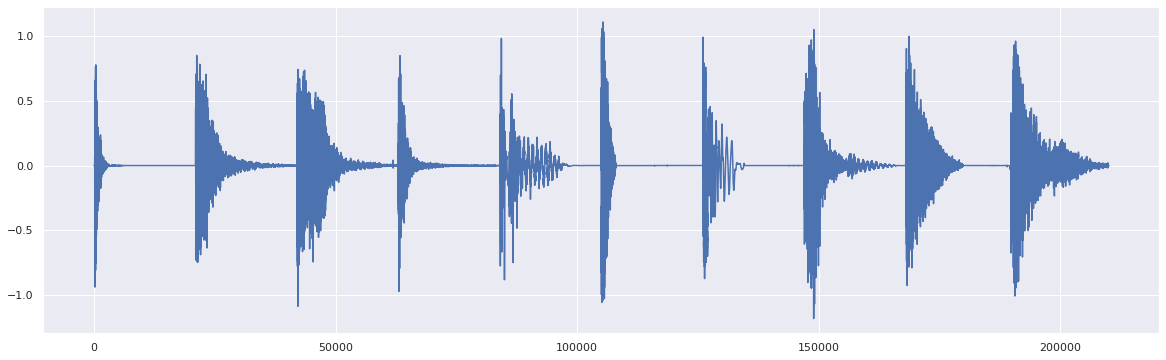

In [204]:
plt.figure(figsize=(20, 6))
plot_and_hear(drums_flatten)


# Class-Conditional/Class-Mixing Sampling

We only trained our classifiers on the VP-cos schedule.
'model_classifier_v2' seems to be a better architecture than the one we presented in the paper

In [5]:
from model_classifier_v2 import Classifier

classifier_dir = os.getcwd() + '/saved_weights/weights_classifier_v2.pt'
checkpoint_classifier = torch.load(classifier_dir)
classifier = Classifier().to(device)
classifier.load_state_dict(checkpoint_classifier['model'])
classifier.eval()


Classifier(
  (conv_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (embedding): RFF_MLP_Block(
    (MLP): ModuleList(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=512, bias=True)
    )
  )
  (downsample): ModuleList(
    (0): DBlock(
      (residual_dense): Conv1d(32, 128, kernel_size=(1,), stride=(4,))
      (layer_1): Conv1d(32, 128, kernel_size=(3,), stride=(4,), padding=(1,))
      (convs): ModuleList(
        (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      )
    )
    (1): DBlock(
      (residual_dense): Conv1d(128, 256, kernel_size=(1,), stride=(6,))
      (layer_1): Conv1d(128, 256, kernel_size=(3,), stride=(6,), padd

There are many way to sample sounds by using the classifier guidance. In fact you can adapt the code of any of the samplers used for unconditional sampling (except the Scipy ODE Solver). Deterministic versions are not that much recommended and we observed that adding a bit of stochasticity helps the model to converge to the good classes. 
For all the functions, alpha_mix refers to a list of floats corresponding to the desired class mix in this order [kick, snare, cymbal]. We recommend you to have the sum of the 3 floats equal to 1.0
There are 2 SDE classes:
- ClassMixingSDE: args of the predict function = (noise, nb_steps, alpha_mix). Corresponds to the 1st SDE Sampling with the classifier guide.
- ClassMixingSDE2: args of the predict function = (noise, nb_steps, alpha_mix). Corresponds to the 2nd SDE Sampling with the classifier guide.

- ClassMixingODE: args of the predict function = (noise, nb_steps, alpha_mix). Corresponds to the ODE discretization with the classifier guide.
- ClassMixingSDE2: args of the predict function = (noise, nb_steps, alpha_mix). Corresponds to the deterministic DDIM with the classifier guide.

- RandomClassConditionalDDIMSampling: args of the predict function = (noise, eta, nb_steps, alpha_mix). Corresponds to the intermediate DDIM with the classifier guide. eta is the stochasticity level

In [178]:
#cm_sampler = ClassMixingSDE(model, classifier, sde)
cm_sampler = ClassMixingSDE2(model, classifier, sde)
#cm_sampler = ClassMixingODE(model, classifier, sde)
#cm_sampler = ClassMixingDDIM(model, classifier, sde)
#cm_sampler = RandomClassMixingDDIM(model, classifier, sde)

In [195]:
noise = torch.randn(10, 21000, device=device)

In [196]:
#drums_cm = cm_sampler.predict(noise, 0.1, 200, [0.5, 0.0, 0.5])
drums_cm = cm_sampler.predict(noise, 200, [0.0, 1.0, 0.0])
drums_cm_flatten = drums_cm.flatten()

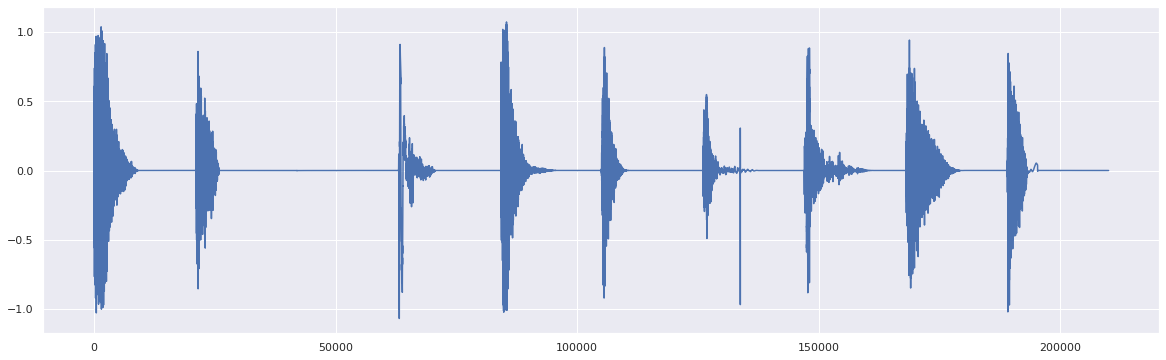

In [197]:
plt.figure(figsize=(20, 6))
plot_and_hear(drums_cm_flatten)


You can check the output class of the classifier

In [198]:
with torch.no_grad():
    print(classifier(drums_cm, 0.0))

tensor([[0.0044, 0.9551, 0.0405],
        [0.0092, 0.7103, 0.2805],
        [0.0031, 0.1845, 0.8124],
        [0.8364, 0.0567, 0.1069],
        [0.0104, 0.9641, 0.0255],
        [0.0095, 0.5894, 0.4010],
        [0.0075, 0.2652, 0.7273],
        [0.0082, 0.9307, 0.0610],
        [0.0092, 0.2320, 0.7588],
        [0.0146, 0.9330, 0.0524]], device='cuda:0')


/home/simon/workspace/CRASH/model_classifier_v2.py:149: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.last_conv(x))


# Inpainting

We implemented two types of SDE Inpainting:
- SDEInpainting: args of the inpaint function = (audio, start, end, nb_steps). First SDE dicretization used to do inpainting
- SDEInpainting2: args of the inpaint function = (audio, start, end, nb_steps). Second SDE dicretization used to do inpainting

In [240]:
#Inpainter = SDEInpainting(model, sde)
Inpainter = SDEInpainting2(model, sde)

You can use a generated drum sound to inpaint it or take a drum sound of a dataset. Here we take a sound of our test set.

In [228]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)


In [252]:
n = random.randint(0, len(filenames))
print(filenames[n])
drums = load_to_device(filenames[n], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/kicks/subdir1076/107590-WA Dubstep KICK 39.wav


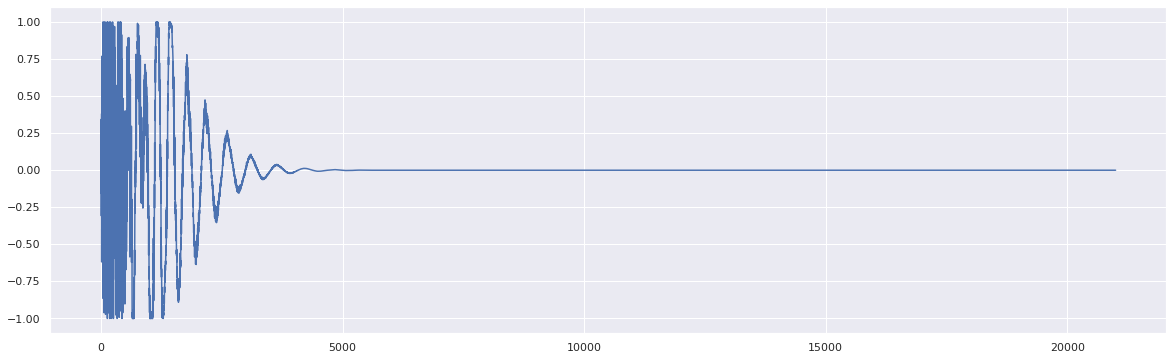

In [253]:
plt.figure(figsize=(20, 6))
plot_and_hear(drums)

In [276]:
drums_inpainted = Inpainter.inpaint(drums, 2000, 6000, 200)


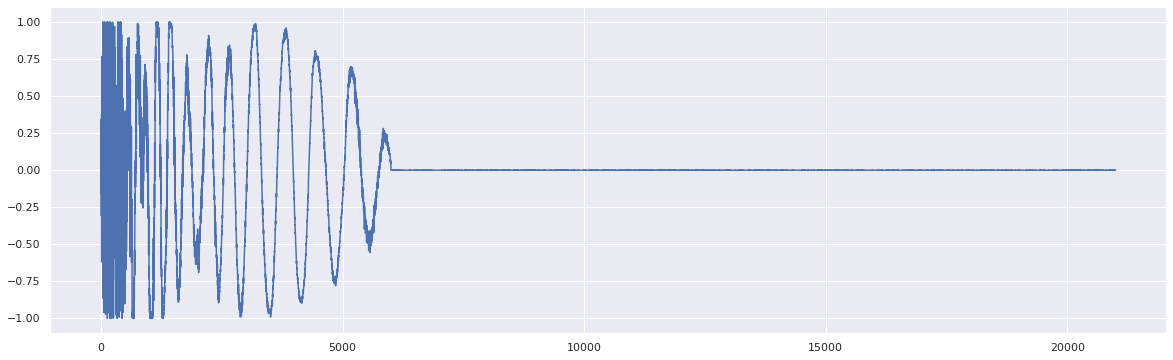

In [277]:
plt.figure(figsize=(20, 6))
plot_and_hear(drums_inpainted)


# Performing interpolations

To perform interpolations between sounds, we need their ODE representation in the latent space t=1. \
To obtain this representation, we have different methods all consisting of applying a discretization of the forward ODE:
- ForwardODESampling: args of the predict function = (audio, nb_steps). It is the Euler discretization of the ODE. It is not the best method.
- ForwardDDIMSampling: args of the predict function = (audio, nb_steps). It is the forward discretization of the reparameterized ODE. It gives good representations for small values of n_steps (like 50). We recommend n_steps > 150 to have a very great approximation of the forward ODE.
- ForwardScipySolver: args of the predict function = (audio). It is the RK45 solver with atol = rtol = 1e-5 applied to the Forward ODE. 


In [295]:
#Forward = ForwardODESampling(model, sde)
Forward = ForwardDDIMSampling(model, sde)
#Forward = ForwardScipySolver(model, sde)

Backward = DDIMSampling(model, sde)

We use here some drum sounds of the test set. 

In [2]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)


In [279]:
n1 = random.randint(0, len(filenames))
n2 = random.randint(0, len(filenames))
print(filenames[n1])
print(filenames[n2])
drum1 = load_to_device(filenames[n1], 21000)
drum2 = load_to_device(filenames[n2], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/snares/subdir909/090896-Snare 11.wav
/home/simon/workspace/datasets/drums_preprocessed/test/hats/subdir1161/116004-THH-06860.wav


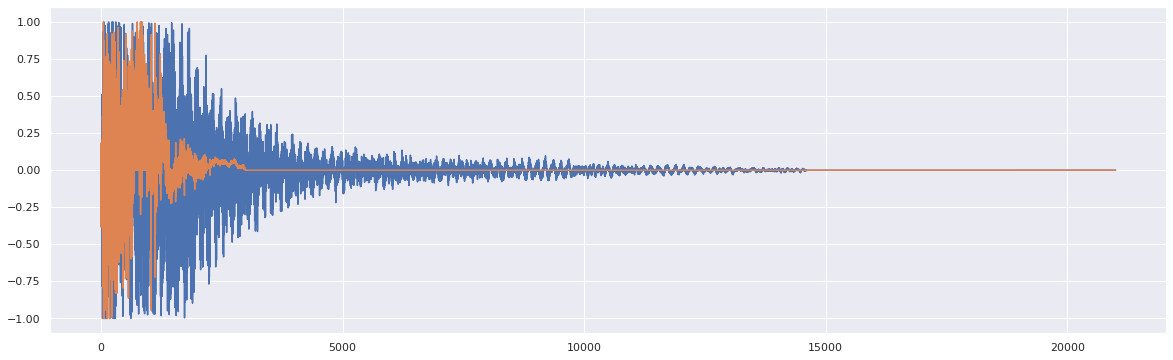

In [282]:
plt.figure(figsize=(20, 6))
plot_and_hear(drum1)
plot_and_hear(drum2)

In [283]:
latent1 = Forward.predict(drum1, 200)
latent2 = Forward.predict(drum2, 200)

You can visualize and hear the latent representation

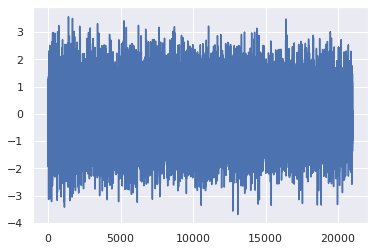

In [290]:
plot_and_hear(latent1)


/home/simon/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/simon/anaconda3/envs/env_pytorch/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

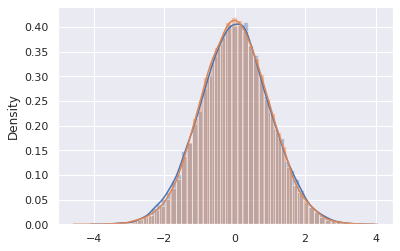

In [293]:
sns.distplot(latent1.cpu())
sns.distplot(latent2.cpu())

Now, you can use the 'compute_interpolation_in_latent' function which does Spherical Linear Interpolation (also called SLERP, see: https://en.wikipedia.org/wiki/Slerp)

In [328]:
latent_mix = compute_interpolation_in_latent(latent1, latent2, [k*0.1 for k in range(11)])

Now, use a backward deterministic discretization to compute the corresponding sounds

In [329]:
interpolation = Backward.predict(latent_mix, 200)

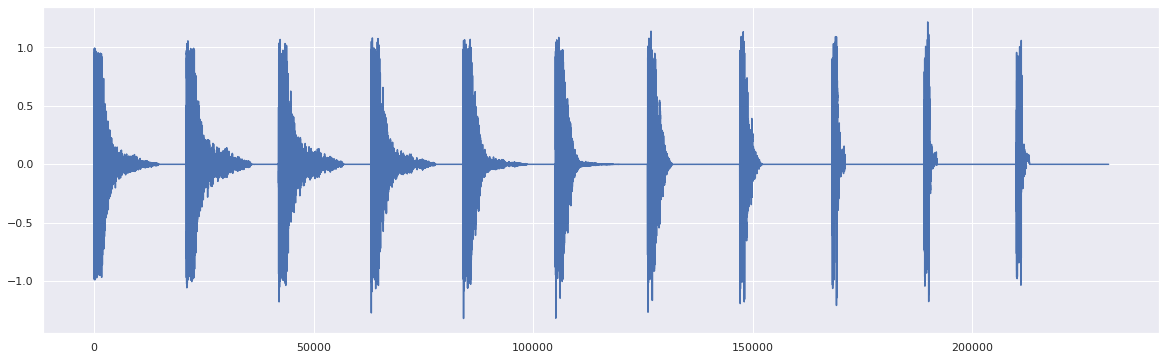

In [331]:
plt.figure(figsize=(20, 6))
plot_and_hear(interpolation.flatten())

# Regenarate a variation of a sound

There are several ways to regenerate a sound. 
- You can noise it at a desired noise level and denoise redenoise it with the method of your choice.
- You can use its latent representation and redenoise it with DDIM with stochasticity/DDIM with stochasticity + classifier guidance

## Regenerate a slightly noised sound with SDE Sampling
RegenerateSDESampling: args of the predict function = (audio, sigma_lvl, nb_steps). It uses the SDESampling2 method to do the resampling. 

In [7]:
Regenerator = RegenerateSDESampling(model, sde)

In [8]:
filenames = glob('/home/simon/workspace/datasets/drums_preprocessed/test/**/*.wav', recursive=True)

In [9]:
n = random.randint(0, len(filenames))
print(filenames[n])
drum = load_to_device(filenames[n], 21000)

/home/simon/workspace/datasets/drums_preprocessed/test/kicks/subdir1003/100231-Kick_4.wav


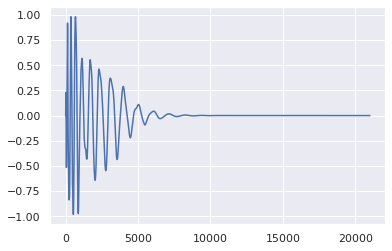

In [10]:
plot_and_hear(drum)

In [ ]:
drum_regen = Regenerator.predict(drum, 0.1, 100)

In [ ]:
plot_and_hear(drum_regen)

## Regenerate a sound using DDIM with stochasticity
We apply a forward deterministic discretization to obtain the latent code and use then a DDIM discretization with stochasticity to regenerate the sound. 
You can also use the class RandomClassMixingDDIM to add classifier guidance to your regeneration.

In [ ]:
Forward = ForwardDDIMSampling(model, sde)
Regenerator = RandomDDIMSampling(model, sde)

In [ ]:
latent = Forward.predict(drum, 200)
drum_regen = Regenerator.predict(drum, 0.1, 200)

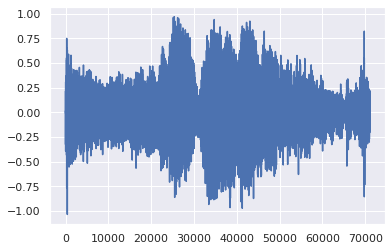

In [96]:
plot_and_hear(drum_regen)

## We hope that this notebook is clear about what you can do with CRASH. Don't hesitate to post a github issue if something is unclear for you. 